/Users/raul/opt/anaconda3/lib/python3.9/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Gurobi status= 2


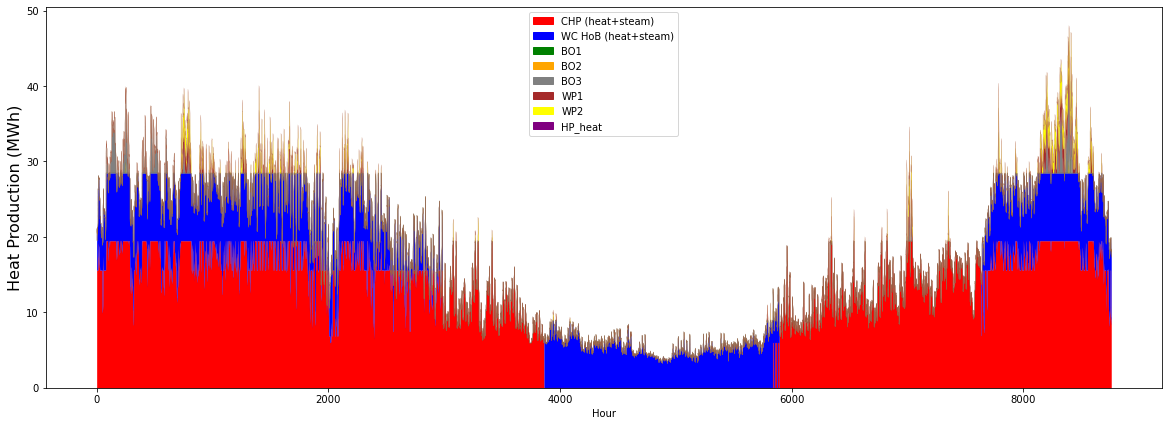

In [10]:
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt
import pulp as pl
import numpy as np

#------------------      INPUT DATA         ---------------------------------------------

#NOTE: Due to confidentiality, the input data cannot be shared. However, these files 
#      contain the hourly distribution of each parameter

heat_demand = pd.read_csv('heat_demand.csv', index_col=False)
el_demand = pd.read_csv('electric_demand.csv', index_col=False)
el_prices = pd.read_csv('el_prices_SE42022.csv', index_col=False)
eon_elprice = pd.read_csv('eon_elprice.csv', index_col=False)
MAN_steam = pd.read_csv('SAFT_steam.csv', index_col=False)



#------------------      CAPACITIES         ---------------------------------------------

# CURRENT BOILERS

resources_heat = {
   
    'CHP_heat': {
        'min': 6,
        'max': 19.5,
        'efficiency': 1,
        'cost': 196.3,
        'CO2': 11
         },
    'WC1_boiler': {
        'min': 1.5,
        'max': 9,
        'efficiency': 0.85,
        'cost': 195.4,
        'CO2': 11
    },
    'bio_oil_boiler_1': {
        'min': 0,
        'max': 6,
        'efficiency': 0.76,
        'cost': 1548.6,
        'CO2': 9
    },
    'bio_oil_boiler_2': {
        'min': 0,
        'max': 6,
        'efficiency': 0.877,
        'cost': 1548.6,
        'CO2': 9
    },
    'wood_pellets_boiler_1': {
        'min': 0.5,
        'max': 3.25,
        'efficiency': 0.877,
        'cost': 455.2,
        'CO2': 19 
    },
    'wood_pellets_boiler_2': {
        'min': 0.5,
        'max': 3.25,
        'efficiency': 0.877,
        'cost': 455.2,
        'CO2': 19 
    },
    'bio_oil_boiler_3': {
        'min': 0,
        'max': 10,
        'efficiency': 0.877,
        'cost': 1548.59,
        'CO2': 9
    }
}


#CHP turubine
resources_el = {
  'CHP_el': {
        'min': 0.8,
        'max': 3.9,
        'efficiency': 0.95,
        'cost': 248.5
    }}

#STEAM COSTS (equal to CHP and WC1 costs)

steam_chp_cost = 196.3
steam_VV_cost = 195.3

#HEAT PUMP

HP={   
        'min': 0,#0.1,
        'max': 0,
        'COP': 3.5
           }


#STORAGE (Input here the desire capacity)

Storage_capacity = 0 #MWh PRELIMINARY VALUE

Storage_losses = 0.002 #99.8%/hourly efficiency
charge_discharge_eff=0.95 #MW

Storage_maxrate = 7 #MW 

#------------------------------------------------------------------------------------------------------
interval = 8760 #hours (If there were any issues with the computing time, especially when considering storage, try reducing the solving interval
                    #  With a 8760 hours interval, the code will solve only one optimization problem for the entire year. 
                    #  With a 25 hour interval, the code will solve 365 problems of 24 hours each and append all the results in the final file.
                    #. This would make the solution a bit more innacurate if there is any storage, but the computing time will be shorter. 
                    #  This won't be necessary with GUROBI, but it could be with other less powerful solvers. 
                    #  Advice: try with 24, 48 and 72 hour intervals if the computing time is too long

    
results = pd.DataFrame(index=heat_demand.index)

end_state=0

for i in range(len(heat_demand) // interval):
    
    # start and end indices for the r interval
    
    start_idx = i * interval
    end_idx = (i + 1) * interval

    
    #------------------      INITIALIZE THE OPTIMIZATION PROBLEM         ---------------------------------------------
    
    prob = LpProblem("District Heating Plant Dispatch Optimization", LpMinimize)
    
    Storage_state=0

    #------------------      DECISION VARIABLES         ---------------------------------------------

   
    variables = LpVariable.dicts("Fuel", ((r, t) for r in resources_heat for t in range(start_idx, end_idx)), lowBound=0, cat='Continuous')
    b_heat = LpVariable.dicts("b_heat",((r, t) for r in resources_heat for t in heat_demand.index), cat="Integer")
    storage_ex=LpVariable.dict("Storage_ex", [t for t in range(start_idx, end_idx)], lowBound=-Storage_maxrate, upBound=Storage_maxrate, cat='Continuous') # MWh
    Storage_state=LpVariable.dict("Storage_state", [t for t in range(start_idx, end_idx)], lowBound=0, upBound=Storage_capacity, cat='Continuous') # MWh
    b_HP = LpVariable.dicts("b_HP", [t for t in range(start_idx, end_idx)], cat="Integer")
    HP_heat=LpVariable.dicts("HP", [t for t in range(start_idx, end_idx)], lowBound=0, cat='Continuous')
    steam_chp=LpVariable.dicts("steam_chp", [t for t in range(start_idx, end_idx)], lowBound=0, upBound=3.7, cat='Continuous')
    steam_VV=LpVariable.dicts("steam_VV", [t for t in range(start_idx, end_idx)], lowBound=0, upBound=4.8, cat='Continuous')
    chp_load = LpVariable.dict("CHP Load", [t for t in range(start_idx, end_idx)], lowBound=0, cat='Continuous') # MWh
    buy_el = LpVariable.dict("Buy Electricity", [t for t in range(start_idx, end_idx)], lowBound=0, cat='Continuous') # MWh
    b_el = LpVariable.dict("b_el", [t for t in range(start_idx, end_idx)], cat="Integer")
  
    #------------------      OBJECTIVE FUNCTION        ---------------------------------------------

   
    prob += lpSum([variables[(r, t)] * resources_heat[r]['cost'] for r in resources_heat for t in range(start_idx, end_idx)])\
        + lpSum([HP_heat[t]*(1/HP['COP'])*float(el_prices.loc[t].to_numpy()) for t in range(start_idx, end_idx)])\
        + lpSum([steam_VV[t]*steam_VV_cost for t in range(start_idx, end_idx)])\
        + lpSum([steam_chp[t]*steam_chp_cost for t in range(start_idx, end_idx)])\
        - (lpSum([el_demand.loc[t] * eon_elprice.loc[t] for t in range(start_idx, end_idx)]) \
          + lpSum([(chp_load[t] - el_demand.loc[t]) * float(el_prices.loc[t].to_numpy()) for t in range(start_idx, end_idx)]) \
          - lpSum(chp_load[t] * resources_el['CHP_el']['cost'] for t in range(start_idx, end_idx)) \
          - lpSum(buy_el[t] * float(el_prices.loc[t].to_numpy()) for t in range(start_idx, end_idx)))
   
     
    #------------------      CONSTRAINTS    ---------------------------------------------

    for t in range(start_idx, end_idx):
        
        # Electricity
        
        prob += chp_load[t] + buy_el[t] >= el_demand.loc[t] #electricity production + bought has to meet eon's demand
        prob += chp_load[t] <= lpSum(resources_el['CHP_el']['max'] * b_el[t]) #maximum CHP turbine load 
        prob += chp_load[t] >= lpSum(resources_el['CHP_el']['min']*b_el[t]) # minimum CHP turbine load
        
       
        prob += buy_el[t] >= 0 #electricity bought must be grater than 0 (also specified in the lower boundary of the variable but this caused some trouble)
        prob += b_el[t] >=0 # Binary variables can only take the values of 0 or 1. These variable could also be defined as Binary in the variable definition part, but they didn't work correctly
        prob += b_el[t] <=1# Binary variables can only take the values of 0 or 1. 
        prob += chp_load[t] <= 0.25*(variables[('CHP_heat', t)]) #Alpha value of the CHP system
        

        # STORAGE SYSTEM
        
            #Charge/Discharge rate

        prob += storage_ex[t]<= Storage_maxrate  #storage_ex[t]>0 Storage charges 
        prob += storage_ex[t]>= -Storage_maxrate       #storage_ex[t]<0 Storage discharges
         
        
        Storage_state[start_idx-1]=end_state #Required in the case of the interval being < 8760
        
            #Losses
        
        prob += Storage_state[t] == Storage_state[t-1]*(1-Storage_losses) + storage_ex[t] 
            #Minimum and maximum state
        prob += Storage_state[t] <= Storage_capacity
        prob += Storage_state[t] >= 0

        
        #Maintenance stops as per 2022 data
        
        if t in range(1, 714):
            
            prob += variables[('wood_pellets_boiler_2', t)]==0 
            prob += variables[('wood_pellets_boiler_1', t)]==0
              
        if t in range(3862, 5837):
            
            prob += b_heat[('CHP_heat', t)]==0 
            prob += variables[('CHP_heat', t)]==0 
            prob += steam_chp[t]==0
        
        
        if t in range(3862, 5981): #Turbine takes a little longer than the CHP boiler to re-start
            prob += chp_load[t]==0
        
        
        if t in range(2989, 3855) or t in range(5893, 7633):
            prob += b_heat[('WC1_boiler', t)]==0   #WC1 Boiler stops in May-June
            prob += steam_VV[t]==0
        
        
       
       
        
          
        
        
        # Total heat production
        
        heat_production = lpSum([variables[(r, t)]  for r in resources_heat]) + HP_heat[t]
        
       # Total heat production must equal the demand + the heat stored
    
        prob += heat_production == heat_demand.loc[t]  + storage_ex[t]*charge_discharge_eff 
       
        # Total steam production must equal the demand 
    
        prob+= steam_chp[t] + steam_VV[t] >= MAN_steam.loc[t]
       
        
        # Binary variable for the boilers
        
        for r in resources_heat:
            
            prob += b_heat[(r, t)] >=0
            prob += b_heat[(r, t)] <=1
        
        
         
        
        
        # Minimum and maximum capacity constraints
        
        prob += b_HP[t] >=0
        prob += b_HP[t] <=1
        prob += HP_heat[t] <= HP['max']*b_HP[t]
        prob += HP_heat[t] >= HP['min']*b_HP[t]
        
        prob += variables[('bio_oil_boiler_1', t)] <= resources_heat['bio_oil_boiler_1']['max']*b_heat[('bio_oil_boiler_1', t)]
        prob += variables[('bio_oil_boiler_2', t)] <= resources_heat['bio_oil_boiler_2']['max']*b_heat[('bio_oil_boiler_2', t)]  
        prob += variables[('bio_oil_boiler_3', t)] <= resources_heat['bio_oil_boiler_3']['max']*b_heat[('bio_oil_boiler_3', t)]
        prob += variables[('bio_oil_boiler_1', t)] >= resources_heat['bio_oil_boiler_1']['min']*b_heat[('bio_oil_boiler_1', t)]
        prob += variables[('bio_oil_boiler_2', t)] >= resources_heat['bio_oil_boiler_2']['min']*b_heat[('bio_oil_boiler_2', t)]  
        prob += variables[('bio_oil_boiler_3', t)] >= resources_heat['bio_oil_boiler_3']['min']*b_heat[('bio_oil_boiler_3', t)] 
        
        prob += variables[('CHP_heat', t)]+steam_chp[t] <=resources_heat['CHP_heat']['max']*b_heat[('CHP_heat', t)]
        prob += variables[('CHP_heat', t)]+steam_chp[t] >=resources_heat['CHP_heat']['min']*b_heat[('CHP_heat', t)]
        prob += variables[('WC1_boiler', t)]+steam_VV[t] <=resources_heat['WC1_boiler']['max']*b_heat[('WC1_boiler', t)]
        prob += variables[('WC1_boiler', t)]+steam_VV[t] >=resources_heat['WC1_boiler']['min']*b_heat[('WC1_boiler', t)]
        
        prob += variables[('wood_pellets_boiler_1', t)] <= resources_heat['wood_pellets_boiler_1']['max']*b_heat[('wood_pellets_boiler_1', t)]
        prob += variables[('wood_pellets_boiler_1', t)] >= resources_heat['wood_pellets_boiler_1']['min']*b_heat[('wood_pellets_boiler_1', t)]
        prob += variables[('wood_pellets_boiler_2', t)] <= resources_heat['wood_pellets_boiler_2']['max']*b_heat[('wood_pellets_boiler_2', t)]
        prob += variables[('wood_pellets_boiler_2', t)] >= resources_heat['wood_pellets_boiler_2']['min']*b_heat[('wood_pellets_boiler_2', t)]
        
        # Start up constraint in the wood pellets boilers
        
        if t>=1 and t<=8751:
        
            for i in range(t, t+9):
                
                prob += b_heat[('wood_pellets_boiler_1', t-1)] - b_heat[('wood_pellets_boiler_1', t)] <= 1- b_heat[('wood_pellets_boiler_1', i)] 

                prob += b_heat[('wood_pellets_boiler_2', t-1)] - b_heat[('wood_pellets_boiler_2', t)] <= 1- b_heat[('wood_pellets_boiler_2', i)] 
 
      

    # Solve the optimization problem
    
    prob.solve(GUROBI(msg = 1))


  
    # Define decision variables
    chp_heat = {}
    Steam_chp = {}
    WC1 = {}
    Steam_VV = {}
    bio_oil_1 = {}
    bio_oil_2 = {}
    wood_pellets_1 = {}
    wood_pellets_2 = {}
    bio_oil_3 = {}  
    HP_h = {}
    Storage_ex={}
    storage_state={}
    Buy_el={}
    Chp_load={}

    
# Populate the results DataFrame with the optimal values of the decision variables

    for p in range(start_idx, end_idx):
        
        chp_heat[p] = variables[('CHP_heat', p)]
        Steam_chp[p] = steam_chp[p]
        WC1[p] = variables[('WC1_boiler', p)]
        Steam_VV[p] = steam_VV[p]
        bio_oil_1[p] = variables[('bio_oil_boiler_1', p)]
        bio_oil_2[p] = variables[('bio_oil_boiler_2', p)]
        bio_oil_3[p] = variables[('bio_oil_boiler_3', p)]
        wood_pellets_1[p] = variables[('wood_pellets_boiler_1', p)]
        wood_pellets_2[p] = variables[('wood_pellets_boiler_2', p)]      
        HP_h[p] = HP_heat[p]
        Storage_ex[p] = storage_ex[p]
        storage_state[p] = Storage_state[p]
        Buy_el[p] = buy_el[p]
        Chp_load[p] = chp_load[p]
    
    for q in range(start_idx, end_idx):
        
       
        results.loc[q, 'KVV_total'] = chp_heat[q].varValue + Steam_chp[q].varValue
        results.loc[q, 'VV_total'] = WC1[q].varValue + Steam_VV[q].varValue
        results.loc[q, 'bio_oil_boiler_1'] = bio_oil_1[q].varValue
        results.loc[q, 'bio_oil_boiler_2'] = bio_oil_2[q].varValue
        results.loc[q, 'bio_oil_boiler_3'] = bio_oil_3[q].varValue
        results.loc[q, 'wood_pellets_boiler_1'] = wood_pellets_1[q].varValue
        results.loc[q, 'wood_pellets_boiler_2'] = wood_pellets_2[q].varValue      
        results.loc[q, 'HP_heat'] = HP_h[q].varValue
        results.loc[q, 'Storage_ex'] = Storage_ex[q].varValue
        results.loc[q, 'storage_state'] = storage_state[q].varValue
        results.loc[q, 'CHP_heat'] = chp_heat[q].varValue
        results.loc[q, 'WC1_boiler'] = WC1[q].varValue
        results.loc[q, 'buy_el'] = Buy_el[q].varValue
        results.loc[q, 'chp_el'] = Chp_load[q].varValue
        results.loc[q, 'CHP_steam'] = Steam_chp[q].varValue
        results.loc[q, 'WC1_steam'] = Steam_VV[q].varValue
    
    end_state=results['storage_state'][end_idx-1]

    # Print the results
    #print(results)

results.to_excel("results_General.xlsx", index=False)



#------------------------------ Production CURVES -----------------------------------------------------


colors = {'CHP (heat+steam)': 'red', 
          'WC HoB (heat+steam)': 'blue', 
          'BO1': 'green', 
          'BO2': 'orange', 
          'BO3': 'grey', 
          'WP1': 'brown', 
          'WP2': 'yellow', 
          'HP_heat': 'purple'}




ax = results.iloc[:, :8].plot.area(stacked=True, figsize=(20,7), color=colors.values(), linewidth=0.05)


# Axis labels and title
ax.set_xlabel('Hour')
ax.set_ylabel('Heat Production (MWh)', fontsize=16)
#ax.set_title('Heat Production by technology', fontsize=16)

#ax.set_xlim([4080, 4104])

# legend
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in colors]
labels = colors.keys()
ax.legend(handles, labels)


# Plot
plt.show()

